# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
from __future__ import division
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income']=='>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income']=='<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

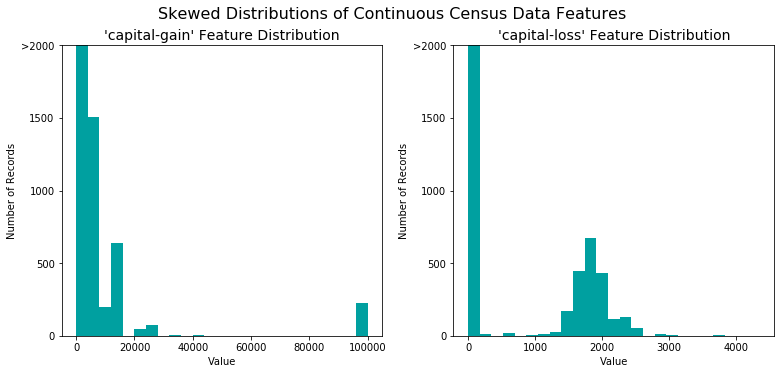

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

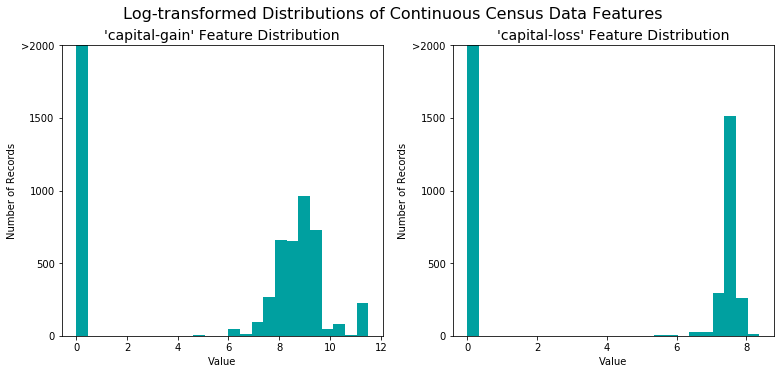

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
data.loc[data['income']=='<=50K','income_raw'] = 0
data.loc[data['income']=='>50K','income_raw'] = 1
income = data['income_raw'].astype('int')

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
# TODO: Calculate accuracy
# accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
accuracy = (11208+0)/45222
# precision = (true_positive)/(true_positive + false_positive)
precision = 11208/(11208+34014)
# recall = (true_positive)/(true_positive + false_negative)
recall = 11208/(11208+0)
    
# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1+0.25)*(precision*recall)/(0.25*precision+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** 
As a matter of fact, one could use any of the methods listed above for classification problem. I chose the following three: Decision Trees, Ensemble Method Random Forest and Support Vector Machines. Lets talk about all three of them in details.

Decision Trees
* Real World application: for long time decision tree algo has been actively used for financial applications such as forming portfolio, predicting trading behavior, asset allocation, etc. (http://edoc.hu-berlin.de/master/andriyashin-anton-2005-03-24/PDF/andriyashin.pdf, http://www.sciencedirect.com/science/article/pii/S0957417415005473)
* Strengths: easy interpretable for humans classification rules, easy visualization of the model, small learning and prediction time, supports categorical and numerical inputs, requires minimal data preparation and handles missing values well
* Weaknesses: non-robust and sensitive to noisy data, tends to overfit, greedy algo so not necessarily the most efficient, can't extrapolate
* Good candidate because: fast, simple and easy interpretable suitable for mixed categorical-numerical data. Especially, if you want to explain how model works and what are the most important characteristics of potential donor.

Random Forest
* Real World application: due to many advantages became extremely popular: (https://www.ncbi.nlm.nih.gov/pubmed/16451683), bioinformatics (http://www.cs.cmu.edu/~qyj/papersA08/11-rfbook.pdf), industrial problems (https://link.springer.com/chapter/10.1007/978-1-84628-814-2_82), credit scoring (http://dl.acm.org/citation.cfm?id=2064595), stock predictions (https://arxiv.org/pdf/1605.00003.pdf), weather  predictions (http://journals.ametsoc.org/doi/abs/10.1175/JAS3918.1)
* Strengths: higher accuaracy compared to all linear methods, robust to the presence of outliers, not sensitive to scaling, works well out-of-box, performs well on data with many features, discrete and continiues values, doesn't have tendency to overfit, has ability to estimate features importance, handles missing values, opportunity to balance classes, scalable
* Weaknesses: compared to decision tree algo it's harder to interprete the model, no p-values outputs, performs poorly on sparse data (text classification, etc), can't extrapolate, in case of categorical feature biased to features with many levels values, requires a lot of memory
* Good candidate because: fast, flexible, robust for high-dimensional mixed-type data

SVM
* Real word application: actively used in bioinformatics for gene selection for cancer classification (https://link.springer.com/article/10.1023%2FA%3A1012487302797 , http://math.bu.edu/people/mkon/SVMSolGeomL11.pdf, https://pdfs.semanticscholar.org/9a44/499b1fac5c30b237bbf241b685e9fc4f91ef.pdf), also used in finances (http://www.svms.org/finance/), hand-written text recognition (https://pdfs.semanticscholar.org/d370/8948a7efb2ef007c4a6e80948bc7a0d164b7.pdf, http://ieeexplore.ieee.org/document/5445830/).
* Strengths: SVM is defined by a convex optimisation problem (so no local minima), using expert knowledge about the problem one could engineer the kernel (so the model will have really good performance), well-established math behind the method, it has a regularisation parameter (allows to manage over-fitting). 
* Weaknesses: you have to make a choice of the kernel and if no prior knowledge is presented it's hard to do, significant limitation is speed and size, both in training and testing, not optimal for multiclass classification, performs poorly on big datasets, noisy datasets, data needs to have clear margin.
* Good candidate because: in general, SVM can produce accurate and robust classification results, it's also recommended to use in case of medium dataset size and not too many features - which is the case

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split
beta = 0.5
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    X_train_slice = X_train.iloc[0:sample_size,:]
    y_train_slice = y_train.iloc[0:sample_size]
    learner.fit(X_train_slice, y_train_slice)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.iloc[0:300,:])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train.iloc[0:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train.iloc[0:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, len(y_train_slice))
        
    # Return the results
    return results

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.


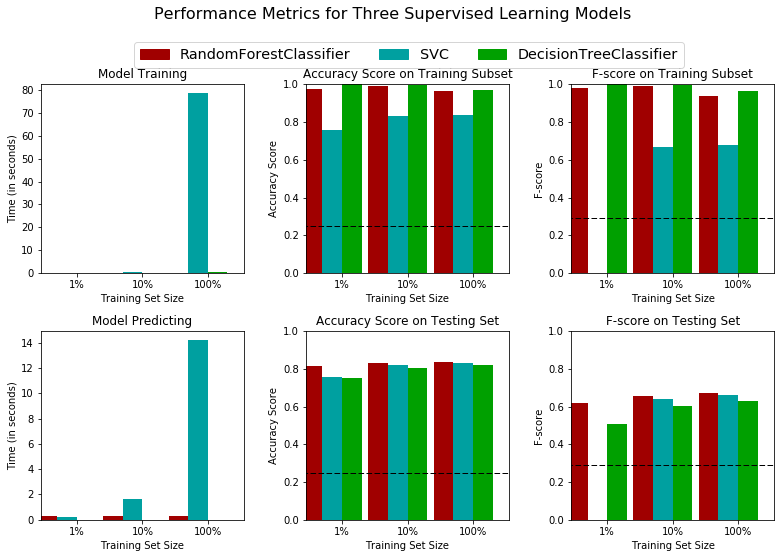

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 10)
clf_B = RandomForestClassifier(random_state = 10, n_jobs = -1)
clf_C = SVC(random_state = 10)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_1 = int(round(X_train.shape[0]*0.01))
samples_10 = int(round(X_train.shape[0]*0.1))
samples_100 = X_train.shape[0]


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** SVM approach was definitely the worst choice between three proposed models. It performed poorly on smaller datasets, training time is almost 15 times longer, but accuracy and F-scores are even lower than Random Forest and not significantly higher than simple Decision Tree Classifier. As for Decision Tree Classifier it tends to overfit data (especially for smaller datasets), as accuracy on training sets is almost 100% but on test set it generalizes poorly (<80%). But despite that, Decision Tree Classifier has two main advantages: it's fast and interpretable. One can extract visual representation of tree and actually evaluate based on what parameters the prediction is made and what features are more important. The prediction time is shorter almost by 40 times compared to Random Forest, as for training time it has advantage only for small datasets. Overall, it's simple and decent model to be used. But if we're not limited in computational powers too much, Random Forest is preffered as overfits the data less and provides higher accuaracy and F-score.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** As Random Forest is an ensemble learning method based on decision trees method approach, let me first briefly explain the idea of decision tree algorithm. This algorithm at every its step tries to find the most important feature of your data, the feature which value separates your data the best way. This process is recursively repeated until you splitted all the data or when splitting no longer adds value to the predictions. It's as simply as series of yes/no question you ask before making decision.  Random Forest splits your data into random pieces and then builds  decision trees on each piece of the data, after that it merges all the decision trees into one. This spliting and learning on separate pieces of data help you to make more generalizable and precise predictions.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

Let's at first take a look at learning behavior depending on three main parameters of Random Forest Classifier:
**n_estimators** - the number of trees in the forest, **max_depth** - the maximum depth of the tree and 
**min_samples_leaf** - the minimum number of samples required to be at a leaf node
That will help us to understand the parameters range for implementing GridSearchCV

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Best accuracy on CV is 84.04% with 30 trees


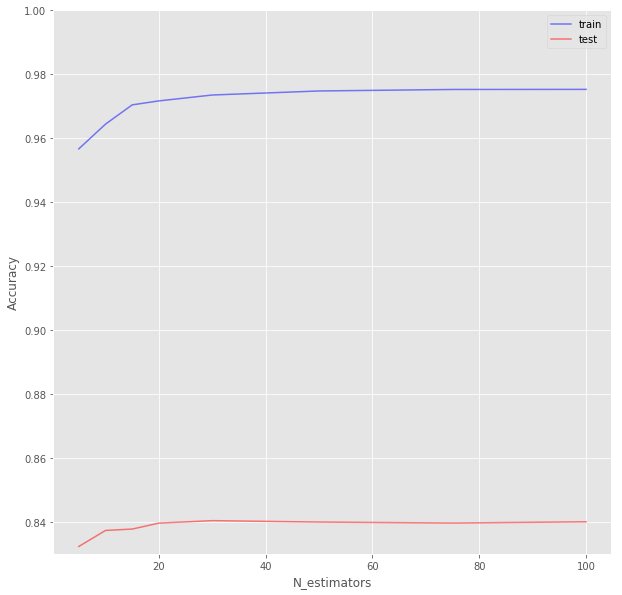

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
# stratify train set for validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
clf = RandomForestClassifier(random_state = 10, n_jobs = -1, oob_score = True)
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
for n_trees in trees_grid:
    clf = RandomForestClassifier(n_estimators = n_trees,random_state = 10, n_jobs = -1, oob_score = True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train_cv, y_train_cv)
        temp_train_acc.append(clf.score(X_train_cv,y_train_cv))
        temp_test_acc.append(clf.score(X_val,y_val))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
train_acc, test_acc = np.asarray(train_acc),np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis = 1))*100, trees_grid[np.argmax(test_acc.mean(axis = 1))]))
      
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(trees_grid, train_acc.mean(axis = 1), alpha = 0.5, color = 'blue', label = 'train')
ax.plot(trees_grid, test_acc.mean(axis = 1), alpha = 0.5, color = 'red', label = 'test')
ax.set_ylim([0.83,1])
ax.legend(loc = 'best')
ax.set_ylabel('Accuracy')
ax.set_xlabel('N_estimators')

Best accuracy on CV is 85.88% with 19 depth


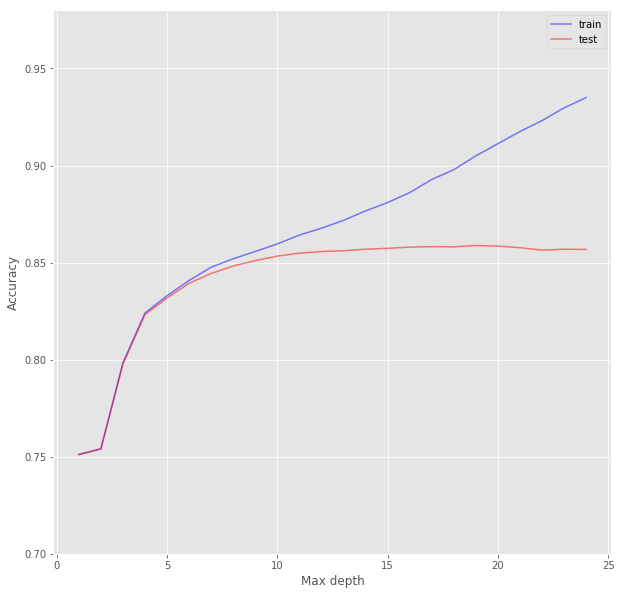

In [139]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
depth_grid = range(1,25)
for depth in depth_grid:
    clf = RandomForestClassifier(n_estimators =60, random_state = 10, n_jobs = -1, oob_score = True, max_depth = depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train_cv, y_train_cv)
        temp_train_acc.append(clf.score(X_train_cv,y_train_cv))
        temp_test_acc.append(clf.score(X_val,y_val))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
train_acc, test_acc = np.asarray(train_acc),np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} depth".format(max(test_acc.mean(axis = 1))*100, depth_grid[np.argmax(test_acc.mean(axis = 1))]))
      
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(depth_grid, train_acc.mean(axis = 1), alpha = 0.5, color = 'blue', label = 'train')
ax.plot(depth_grid, test_acc.mean(axis = 1), alpha = 0.5, color = 'red', label = 'test')
ax.set_ylim([0.7,0.98])
ax.legend(loc = 'best')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Max depth')

Best accuracy on CV is 85.89% with 3 min_samples_leaf


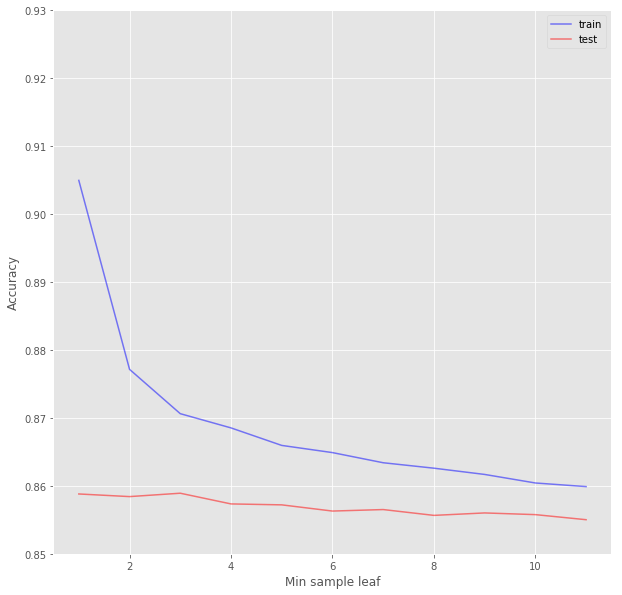

In [138]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = range(1,12)
for min_leaf in min_samples_leaf_grid:
    clf = RandomForestClassifier(n_estimators =60, max_depth = 19, random_state = 10, min_samples_leaf = min_leaf, n_jobs = -1, oob_score = True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train_cv, y_train_cv)
        temp_train_acc.append(clf.score(X_train_cv,y_train_cv))
        temp_test_acc.append(clf.score(X_val,y_val))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
train_acc, test_acc = np.asarray(train_acc),np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis = 1))*100, min_samples_leaf_grid[np.argmax(test_acc.mean(axis = 1))]))
      
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis = 1), alpha = 0.5, color = 'blue', label = 'train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis = 1), alpha = 0.5, color = 'red', label = 'test')
ax.set_ylim([0.85,0.93])
ax.legend(loc = 'best')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Min sample leaf')



In [145]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state = 10, n_jobs = -1, oob_score = True)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [30, 100],'max_depth': [5, 10, 15, 20],'min_samples_leaf': [1, 3, 5, 7]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=2)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8371
F-score on testing data: 0.6708

Optimized Model
------
Final accuracy score on the testing data: 0.8609
Final F-score on the testing data: 0.7340


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |       0.8371      |     0.8609      |
| F-score        |     0.2917          |       0.6708      |     0.7340      |
 

In [ ]:
*Answer:* Even unoptimized model provides significantly better results than benchmark predictor. By optimization of three
          main parameters for Random Forest Classifier (number of estimators, max depth, min leafs) it improved F-score
          by 10% and improved accuracy by 3% only.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** Well, I'll start with features having least importance to my opinion: 'native-country' - even though it seems logical to assume that salary significantly depends on the country, and for some countries the average salary higher than for others, in our dataset 'native-country' feature is too skewed (91% is from US) to be valuable for predictions. The same skewed problem is observed in 'race' feature. As for 'capital-loss' and 'capital-gain', even though income correlates with those parameters significantly - both features have mostly zero values, and thus won't be useful  for building the model. So this leaves us with these features: age,	workclass,	education_level,	education-num,	marital-status,	occupation,	relationship, sex, hours-per-week. 
Two features 'education_level' and 'education-num' represent basically the same, but 'education-num' is continious variable and for 'education_level' we use OHE - what leads to many sparce separate variables with less importance. So let's cross out 'education_level'. From basic logic and correlation tables, age, hours-per-week are features of significant importance. What about 'sex'? - well, according to the table only 11% of women vs 31% of men have income higher 50k, so I assume it should be important too. From many sociological researches I also know that income is highly correlated with marital status, married people earn more money (http://www.today.com/money/why-married-people-tend-be-wealthier-its-complicated-1C8364877). There are a lot of different possible explainations, but I won't go into details. 'relationship' is strongly correlated with 'marital-status', so let's cross it out as well. As for 'occupation' and 'workclass' even though they're important, the labeling is inconsclusive and, I assume, they should have less importance. All that being said, leads us to the following 5 features: age, education-num, marital-status, sex, hours-per-week. To range within the group I used general understanding and logic: age is the most important feature, as it correlates with carrer promotion and salary increase; then education; then  hours-per-week - as more you work, more you earn, then sex and marital-status.

Final assumption of features importance:  age, education_level, hours-per-week, sex, marital-status.



In [198]:
features_raw['capital-loss'].value_counts().head()

0.000000    43082
0.436639      294
0.453857      246
0.433196      228
0.554408       68
Name: capital-loss, dtype: int64

In [199]:
features_raw['capital-gain'].value_counts().head()

0.000000    41432
0.150242      498
0.076881      391
0.072981      351
1.000000      229
Name: capital-gain, dtype: int64

In [214]:
features_raw.corr()

,age,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,0.037623,0.079683,0.059351,0.101992,0.237040
education-num,0.037623,1.000000,0.126907,0.081711,0.146206,0.332800
capital-gain,0.079683,0.126907,1.000000,-0.032102,0.083880,0.221034
capital-loss,0.059351,0.081711,-0.032102,1.000000,0.054195,0.148687
hours-per-week,0.101992,0.146206,0.083880,0.054195,1.000000,0.227199
income,0.237040,0.332800,0.221034,0.148687,0.227199,1.000000


In [212]:
features_raw['native-country'].value_counts(normalize=True).head()

 United-States    0.913095
 Mexico           0.019968
 Philippines      0.006258
 Germany          0.004268
 Puerto-Rico      0.003870
Name: native-country, dtype: float64

In [211]:
features_raw['race'].value_counts(normalize=True).head()

 White                 0.860267
 Black                 0.093494
 Asian-Pac-Islander    0.028813
 Amer-Indian-Eskimo    0.009619
 Other                 0.007806
Name: race, dtype: float64

In [210]:
features_raw['income'] = income
features_raw.groupby('sex')['income'].value_counts(normalize=True)

sex      income
 Female  0         0.886424
         1         0.113576
 Male    0         0.687523
         1         0.312477
Name: income, dtype: float64

In [215]:
features_raw['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
       ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
       ' Craft-repair', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [216]:
features_raw['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

In [218]:
features_raw['relationship'].unique()


array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [219]:
features_raw['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

In [159]:
# TODO: Import a supervised learning model that has 'feature_importances_'
# I use RandomForestClassifier with optimized by GridSearchCV para- it has attribute 'feature_importances' 

# TODO: Train the supervised model on the training set 
model = best_clf
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_


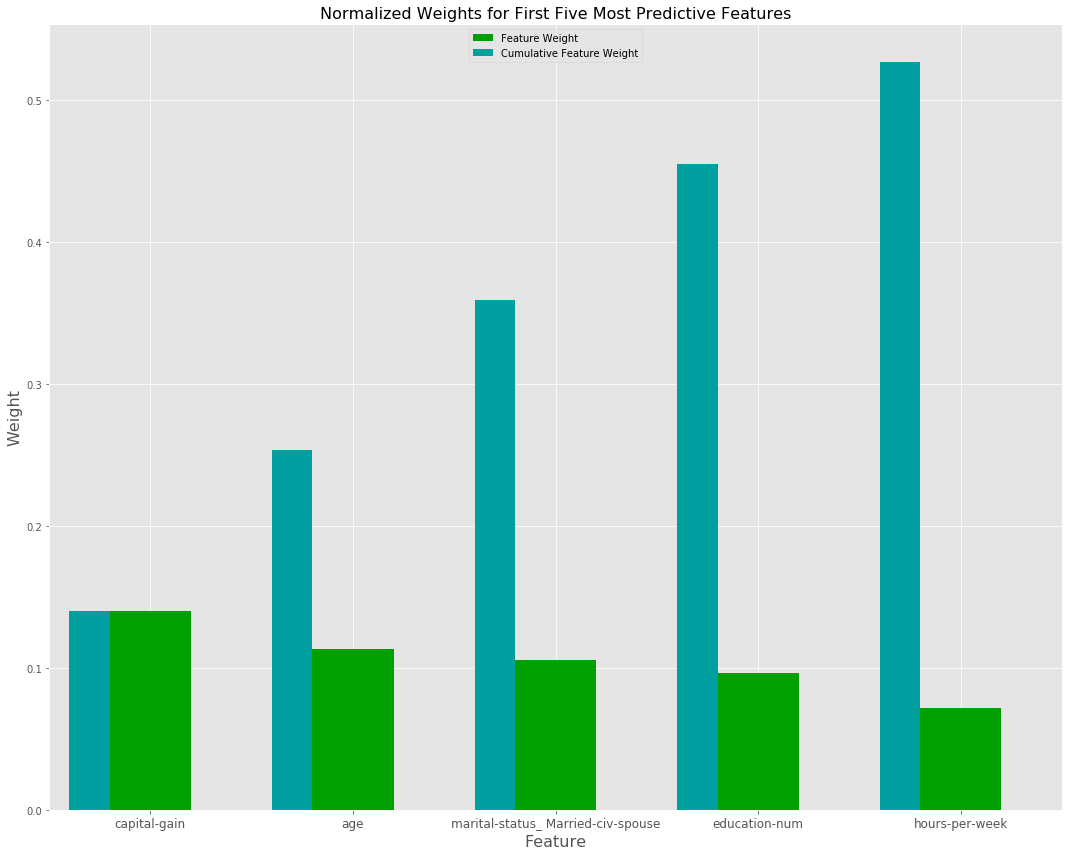

In [181]:
# Plot
reload(vs)
vs.feature_plot(importances, X_train, y_train)

**Answer:** Well, my assumptions were significantly different. As you see from the plot, the most influence has 'capital-gain' feature. As I said before, I observed high correlation of 'capital-gain' and 'income', but I thought because 'capital-gain' has mostly zero values it would be hard for the model to catch the trend - I was wrong. From basic logic to see this feature as important is totally understandable - if you earn above average, you're able to save money and increase capital. As for age, education_num, hours-per-week sequence, the assumptions are correct. But surpusingly, marital-status = married-civ-spouse is slightly higher important then education or work hours.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [220]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8609
F-score on testing data: 0.7340

Final Model trained on reduced data
------
Accuracy on testing data: 0.8399
F-score on testing data: 0.6786


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

The accuracy of model trained on reduced data is comparable to results achieved by unoptimized model trained on full dataset, and varies only by few percents. But as in every task, the main question is "What metric is the most important for us?". To my understanding we care about precision the most and F-score with beta = 0.5 is an appropriate metric to look at (compared to accuracy). Reducing number of features to five most important, we decrease our F-score by almost 8%. So, probably, reducing number of features is not the best approach for Random Forest. If one is interested in decreasing training time, it's better to use different approaches, like lazy learning or implement online learning.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.